In [2]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [3]:
cwd = os.path.join(os.getcwd(), 'Group Coursework Brief-20221106', 'Data_Files', 'Data_Files')
dirName_trainData = os.path.join(cwd, 'epl-full-training.csv')

In [4]:
df_epl_train = pd.read_csv(dirName_trainData)
cols = ["Div","Date","HomeTeam","AwayTeam","FTHG", "FTAG","FTR","HTHG","HTAG","HTR","HS","AS", "HST","AST","HF","AF","HC","AC","HY","AY","HR","AR"]

df_epl_train = df_epl_train.loc[:, cols]
df_epl_train = df_epl_train.reset_index(drop=True)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df_epl_train.head())

/var/folders/hj/3fjyhjt93m7c5t7sztk1h8200000gn/T/ipykernel_4430/3361019305.py:1: DtypeWarning: Columns (98) have mixed types. Specify dtype option on import or set low_memory=False.
  df_epl_train = pd.read_csv(dirName_trainData)


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,E0,17/08/2002,Blackburn,Sunderland,0.0,0.0,D,0.0,0.0,D,15.0,7.0,5.0,3.0,14.0,11.0,9.0,1.0,1.0,2.0,0.0,0.0
1,E0,17/08/2002,Charlton,Chelsea,2.0,3.0,A,2.0,1.0,H,5.0,21.0,5.0,12.0,10.0,12.0,3.0,6.0,0.0,3.0,1.0,0.0
2,E0,17/08/2002,Everton,Tottenham,2.0,2.0,D,1.0,0.0,H,13.0,10.0,9.0,5.0,18.0,4.0,10.0,5.0,1.0,1.0,0.0,0.0
3,E0,17/08/2002,Fulham,Bolton,4.0,1.0,H,3.0,1.0,H,13.0,3.0,6.0,1.0,16.0,12.0,7.0,4.0,1.0,2.0,0.0,0.0
4,E0,17/08/2002,Leeds,Man City,3.0,0.0,H,2.0,0.0,H,13.0,18.0,8.0,10.0,13.0,13.0,2.0,7.0,1.0,1.0,0.0,0.0


In [5]:
# Transform the date column from strings into datetime objects
df_epl_train["Date"] = pd.to_datetime(df_epl_train["Date"], dayfirst=True)

In [6]:
df_epl_train.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
0,E0,2002-08-17,Blackburn,Sunderland,0.0,0.0,D,0.0,0.0,D,...,5.0,3.0,14.0,11.0,9.0,1.0,1.0,2.0,0.0,0.0
1,E0,2002-08-17,Charlton,Chelsea,2.0,3.0,A,2.0,1.0,H,...,5.0,12.0,10.0,12.0,3.0,6.0,0.0,3.0,1.0,0.0
2,E0,2002-08-17,Everton,Tottenham,2.0,2.0,D,1.0,0.0,H,...,9.0,5.0,18.0,4.0,10.0,5.0,1.0,1.0,0.0,0.0
3,E0,2002-08-17,Fulham,Bolton,4.0,1.0,H,3.0,1.0,H,...,6.0,1.0,16.0,12.0,7.0,4.0,1.0,2.0,0.0,0.0
4,E0,2002-08-17,Leeds,Man City,3.0,0.0,H,2.0,0.0,H,...,8.0,10.0,13.0,13.0,2.0,7.0,1.0,1.0,0.0,0.0


AIM:

1) Given match date, Filter the dataframe for the all games of current year

2) Given HomeTeam & AwayTeam, Filter database for all games (in this time frame) where HomeTeam is Home against all other teams, same for AwayTeam -> Return two filtered dataframes

3) Average these past stats for the home and away teams from current and last season

4) Give the home and away teams ratings based upon the weighted sum of the past stats

5) Create a expected goals predictor using linear/polynomial regression using the past average stats

6) Final Classifier takes as input: Home and Away Team ratings, expected goals, day, month, hometeam and awayteam

In [7]:
# This function will take as input a date, HomeTeam and AwayTeam and output two filtered dataframe

def get_season_start_date(date):
    if date.month <= 7:
        return datetime(date.year-1, 8, 1)
    return datetime(date.year, 8, 1)

def filter_dataframe_by_hometeam_recent_season(df, date, HomeTeam):
    # Convert the input string date into datetime
    date = pd.to_datetime(date, dayfirst=True)

    # Filter the dataframe to include only rows where Dateinput(first day of season) && HomeTeam=input(HomeTeam)
    df_filtered = df.copy()
    df_filtered = df_filtered[(df_filtered.Date<date) & (df_filtered.Date>get_season_start_date(date)) & (df_filtered.HomeTeam==HomeTeam)]

    # Return filtered dataframe
    return df_filtered

def filter_dataframe_by_awayteam_recent_season(df, date, AwayTeam):
    # Convert the input string date into datetime
    date = pd.to_datetime(date, dayfirst=True)

    # Filter the dataframe to include only rows where Dateinput(first day of season) && HomeTeam=input(HomeTeam)
    df_filtered = df.copy()
    df_filtered = df_filtered[(df_filtered.Date<date) & (df_filtered.Date>get_season_start_date(date)) & (df_filtered.AwayTeam==AwayTeam)]

    # Return filtered dataframe
    return df_filtered

# For Example:
# date = "24/06/2020"
# HomeTeam = "Newcastle"
# AwayTeam = "Aston Villa"

# An example to see what the function does:
df_epl_train_filtered_Home = filter_dataframe_by_hometeam_recent_season(df_epl_train, "24/06/2020", "Newcastle")
df_epl_train_filtered_Away = filter_dataframe_by_awayteam_recent_season(df_epl_train, "24/06/2020", "Aston Villa")
print(df_epl_train_filtered_Home)
print(df_epl_train_filtered_Away)

     Div       Date   HomeTeam          AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
6468  E0 2019-08-11  Newcastle           Arsenal   0.0   1.0   A   0.0   0.0   
6495  E0 2019-08-31  Newcastle           Watford   1.0   1.0   D   1.0   1.0   
6515  E0 2019-09-21  Newcastle          Brighton   0.0   0.0   D   0.0   0.0   
6539  E0 2019-10-06  Newcastle        Man United   1.0   0.0   H   0.0   0.0   
6556  E0 2019-10-27  Newcastle            Wolves   1.0   1.0   D   1.0   0.0   
6573  E0 2019-11-09  Newcastle       Bournemouth   2.0   1.0   H   1.0   1.0   
6590  E0 2019-11-30  Newcastle          Man City   2.0   2.0   D   1.0   1.0   
6616  E0 2019-12-08  Newcastle       Southampton   2.0   1.0   H   0.0   0.0   
6634  E0 2019-12-21  Newcastle    Crystal Palace   1.0   0.0   H   0.0   0.0   
6650  E0 2019-12-28  Newcastle           Everton   1.0   2.0   A   0.0   1.0   
6661  E0 2020-01-01  Newcastle         Leicester   0.0   3.0   A   0.0   2.0   
6686  E0 2020-01-18  Newcastle          

In [8]:
# This function takes as input a filtered dataframe from previous cell, features to average and a dictionary,
# it then appends an average of each feature to the dictionary

def average_columns(features, avg_features, filtered_df):
    for feature in features:
        df_col_means = filtered_df[feature].mean()
        avg_features[feature].append(df_col_means)

In [9]:
# Run the two functions for each row of our df_epl_train dataframe to fill dictionary with AVG for each match
# NOTE: Some matches won't have past stats since its the first game of the season or we might not have past data

features = ["FTHG","FTAG","HTHG","HTAG","HS","AS","HST","AST","HF","AF","HC","AC","HY","AY","HR","AR"]
avg_features_HOME = {
                        "FTHG": [],
                        "FTAG": [],
                        "HTHG": [],
                        "HTAG": [],
                        "HS"  : [],
                        "AS"  : [],
                        "HST" : [],
                        "AST" : [],
                        "HF"  : [],
                        "AF"  : [],
                        "HC"  : [],
                        "AC"  : [],
                        "HY"  : [],
                        "AY"  : [],
                        "HR"  : [],
                        "AR"  : []
                    }

avg_features_AWAY = {
                        "FTHG": [],
                        "FTAG": [],
                        "HTHG": [],
                        "HTAG": [],
                        "HS"  : [],
                        "AS"  : [],
                        "HST" : [],
                        "AST" : [],
                        "HF"  : [],
                        "AF"  : [],
                        "HC"  : [],
                        "AC"  : [],
                        "HY"  : [],
                        "AY"  : [],
                        "HR"  : [],
                        "AR"  : []
                    }

# Run the two functions on each row of the df_epl_train and fill the dictionary
# We need to do this for the HOME filtered dataframe, and AWAY filtered dataframe

# For each row in our original dataframe
for index, row in df_epl_train.iterrows():
    # Filter the dataframe to only show matches played between those teams and before the certain date
    df_epl_train_filtered_Home = filter_dataframe_by_hometeam_recent_season(df_epl_train, row["Date"],row["HomeTeam"])
    df_epl_train_filtered_Away = filter_dataframe_by_awayteam_recent_season(df_epl_train, row["Date"],row["AwayTeam"])
    # Get averages from the filtered dataframe and add the the dictionary
    average_columns(features, avg_features_HOME, df_epl_train_filtered_Home)
    average_columns(features, avg_features_AWAY, df_epl_train_filtered_Away)
    
# Check this is correct
# print(avg_features_HOME)
# print(avg_features_AWAY)

In [10]:
# Add a column for each of these feature averages using the list of values from the dictionary
df_epl_train_updated = df_epl_train.copy()
features = ["FTHG","FTAG","HTHG","HTAG","HS","AS","HST","AST","HF","AF","HC","AC","HY","AY","HR","AR"]

for feature in features:
    # Get the list of averages for a certain feature from the dicitonary
    feature_vals_HOME = avg_features_HOME[feature]
    feature_vals_AWAY = avg_features_AWAY[feature]
    # Add the list of averages into the dataframe for that certain feature
    df_epl_train_updated[feature + "_AVG_Home"] = feature_vals_HOME
    df_epl_train_updated[feature + "_AVG_Away"] = feature_vals_AWAY

In [11]:
# Now this dataframe contains our original data + the average of the past stats (Home & Away) for each row
df_epl_train_updated

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,AC_AVG_Home,AC_AVG_Away,HY_AVG_Home,HY_AVG_Away,AY_AVG_Home,AY_AVG_Away,HR_AVG_Home,HR_AVG_Away,AR_AVG_Home,AR_AVG_Away
0,E0,2002-08-17,Blackburn,Sunderland,0.0,0.0,D,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,2002-08-17,Charlton,Chelsea,2.0,3.0,A,2.0,1.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,2002-08-17,Everton,Tottenham,2.0,2.0,D,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,2002-08-17,Fulham,Bolton,4.0,1.0,H,3.0,1.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,2002-08-17,Leeds,Man City,3.0,0.0,H,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7731,E0,2022-11-06,Chelsea,Arsenal,0.0,1.0,A,0.0,0.0,D,...,5.000000,4.000000,2.200000,1.333333,1.600000,1.833333,0.2,0.000000,0.0,0.0
7732,E0,2022-11-06,Aston Villa,Man United,3.0,1.0,H,2.0,1.0,H,...,4.000000,2.833333,2.000000,0.666667,0.833333,3.000000,0.0,0.000000,0.0,0.0
7733,E0,2022-11-06,Southampton,Newcastle,1.0,4.0,A,0.0,1.0,A,...,5.833333,5.833333,1.333333,2.166667,1.833333,1.500000,0.0,0.166667,0.0,0.0
7734,E0,2022-11-06,West Ham,Crystal Palace,1.0,2.0,A,1.0,1.0,D,...,3.333333,2.800000,1.166667,2.000000,2.166667,2.600000,0.0,0.200000,0.0,0.0


In [12]:
# Now we loop through the updated dataframe and for each row average the HomeAvgStats and AwayAvgStats using 
# weights to give higher importance to some specific stats. This results in creating and adding two final columns.

features = ["FTHG","FTAG","HTHG","HTAG","HS","AS","HST","AST","HF","AF","HC","AC","HY","AY","HR","AR"]
feature_weights = {
                        "FTHG": 0,
                        "FTAG": 0,
                        "HTHG": 0,
                        "HTAG": 0,
                        "HS"  : 2,
                        "AS"  : 2,
                        "HST" : 2.5,
                        "AST" : 2.5,
                        "HF"  : 1.5,
                        "AF"  : 1.5,
                        "HC"  : 0.5,
                        "AC"  : 0.5,
                        "HY"  : 0.5,
                        "AY"  : 0.5,
                        "HR"  : 0.5,
                        "AR"  : 0.5
                    }
    
Home_Weighted_Avg = []
Away_Weighted_Avg = []

for index, row in df_epl_train_updated.iterrows():
    home_vals = []
    away_vals = []
    for feature in features:
        current_feature_HOME = feature + "_AVG_Home"
        current_feature_AWAY = feature + "_AVG_Away"
        current_val_HOME = row[current_feature_HOME]*feature_weights[feature]
        current_val_AWAY = row[current_feature_AWAY]*feature_weights[feature]
        home_vals.append(current_val_HOME)
        away_vals.append(current_val_AWAY)
    Home_Weighted_Avg.append(sum(home_vals)/len(home_vals))
    Away_Weighted_Avg.append(sum(away_vals)/len(away_vals))

df_epl_train_final = df_epl_train.copy()
df_epl_train_final["HomeTeam_Rating"] = Home_Weighted_Avg
df_epl_train_final["AwayTeam_Rating"] = Away_Weighted_Avg

# Check if its working correctly
df_epl_train_final

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HF,AF,HC,AC,HY,AY,HR,AR,HomeTeam_Rating,AwayTeam_Rating
0,E0,2002-08-17,Blackburn,Sunderland,0.0,0.0,D,0.0,0.0,D,...,14.0,11.0,9.0,1.0,1.0,2.0,0.0,0.0,NaN,NaN
1,E0,2002-08-17,Charlton,Chelsea,2.0,3.0,A,2.0,1.0,H,...,10.0,12.0,3.0,6.0,0.0,3.0,1.0,0.0,NaN,NaN
2,E0,2002-08-17,Everton,Tottenham,2.0,2.0,D,1.0,0.0,H,...,18.0,4.0,10.0,5.0,1.0,1.0,0.0,0.0,NaN,NaN
3,E0,2002-08-17,Fulham,Bolton,4.0,1.0,H,3.0,1.0,H,...,16.0,12.0,7.0,4.0,1.0,2.0,0.0,0.0,NaN,NaN
4,E0,2002-08-17,Leeds,Man City,3.0,0.0,H,2.0,0.0,H,...,13.0,13.0,2.0,7.0,1.0,1.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7731,E0,2022-11-06,Chelsea,Arsenal,0.0,1.0,A,0.0,0.0,D,...,20.0,13.0,4.0,6.0,5.0,2.0,0.0,0.0,6.081250,6.255208
7732,E0,2022-11-06,Aston Villa,Man United,3.0,1.0,H,2.0,1.0,H,...,6.0,12.0,3.0,5.0,3.0,3.0,0.0,0.0,6.302083,6.750000
7733,E0,2022-11-06,Southampton,Newcastle,1.0,4.0,A,0.0,1.0,A,...,7.0,10.0,8.0,2.0,1.0,0.0,0.0,0.0,7.244792,6.776042
7734,E0,2022-11-06,West Ham,Crystal Palace,1.0,2.0,A,1.0,1.0,D,...,10.0,7.0,2.0,5.0,1.0,1.0,0.0,0.0,6.140625,7.543750


In [13]:
# Turn the catergorical data into labels using same method from before
df_epl_train_final["AwayTeam_Enc"] = df_epl_train_final["AwayTeam"].astype("category").cat.codes
df_epl_train_final["HomeTeam_Enc"] = df_epl_train_final["HomeTeam"].astype("category").cat.codes

# Transform the date column into day and month columns and Add into dataframe (Extract days & months from date)
df_epl_train_final["Date"] = pd.to_datetime(df_epl_train_final["Date"])
df_epl_train_final["Day"] = df_epl_train_final["Date"].dt.day
df_epl_train_final["Month"] = df_epl_train_final["Date"].dt.month 
df_epl_train_final["Year"] = df_epl_train_final["Date"].dt.year

# Add average values from updated dataframe
df_epl_train_final["FTHG_AVG"] = df_epl_train_updated["FTHG_AVG_Home"]
df_epl_train_final["FTAG_AVG"] = df_epl_train_updated["FTAG_AVG_Away"]
df_epl_train_final["HTHG_AVG"] = df_epl_train_updated["HTHG_AVG_Home"]
df_epl_train_final["HTAG_AVG"] = df_epl_train_updated["HTAG_AVG_Away"]
df_epl_train_final["HS_AVG"] = df_epl_train_updated["HS_AVG_Home"]
df_epl_train_final["AS_AVG"] = df_epl_train_updated["AS_AVG_Away"]
df_epl_train_final["HST_AVG"] = df_epl_train_updated["HST_AVG_Home"]
df_epl_train_final["AST_AVG"] = df_epl_train_updated["AST_AVG_Away"]
df_epl_train_final["HF_AVG"] = df_epl_train_updated["HF_AVG_Home"]
df_epl_train_final["AF_AVG"] = df_epl_train_updated["AF_AVG_Away"]
df_epl_train_final["HC_AVG"] = df_epl_train_updated["HC_AVG_Home"]
df_epl_train_final["AC_AVG"] = df_epl_train_updated["AC_AVG_Away"]
df_epl_train_final["HY_AVG"] = df_epl_train_updated["HY_AVG_Home"]
df_epl_train_final["AY_AVG"] = df_epl_train_updated["AY_AVG_Away"]
df_epl_train_final["HR_AVG"] = df_epl_train_updated["HR_AVG_Home"]
df_epl_train_final["AR_AVG"] = df_epl_train_updated["AR_AVG_Away"]

# Check the final updated dataframe
df_epl_train_final

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST_AVG,AST_AVG,HF_AVG,AF_AVG,HC_AVG,AC_AVG,HY_AVG,AY_AVG,HR_AVG,AR_AVG
0,E0,2002-08-17,Blackburn,Sunderland,0.0,0.0,D,0.0,0.0,D,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,2002-08-17,Charlton,Chelsea,2.0,3.0,A,2.0,1.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,2002-08-17,Everton,Tottenham,2.0,2.0,D,1.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,2002-08-17,Fulham,Bolton,4.0,1.0,H,3.0,1.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,2002-08-17,Leeds,Man City,3.0,0.0,H,2.0,0.0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7731,E0,2022-11-06,Chelsea,Arsenal,0.0,1.0,A,0.0,0.0,D,...,3.600000,4.166667,8.200000,9.833333,6.200000,4.000000,2.200000,1.833333,0.2,0.0
7732,E0,2022-11-06,Aston Villa,Man United,3.0,1.0,H,2.0,1.0,H,...,4.833333,5.000000,10.833333,12.666667,4.833333,2.833333,2.000000,3.000000,0.0,0.0
7733,E0,2022-11-06,Southampton,Newcastle,1.0,4.0,A,0.0,1.0,A,...,5.500000,4.333333,9.666667,9.000000,5.333333,5.833333,1.333333,1.500000,0.0,0.0
7734,E0,2022-11-06,West Ham,Crystal Palace,1.0,2.0,A,1.0,1.0,D,...,4.166667,3.400000,9.000000,11.000000,3.166667,2.800000,1.166667,2.600000,0.0,0.0


In [14]:
# NOTE: We must remove the rows in the dataframe where the average values of stats/features are 'nan';
# we get these values because either its the teams first game of the season OR because we have
# not got the past stats for these matches. We cannot use the 'nan' values for the classifier training and 
# hence have to remove these rows. We can then train a classifier using this final dataframe.

# In the final model/classifier, in the case where we DO NOT have these past stats of the teams playing, 
# we need to switch back to using the OLD classifier which only took the 4 basic fetaures: day, month, 
# HomeTeam and AwayTeam.

# In the case where we DO have these past stats for the teams, we can use this model/classifier 
# and input the features like HST_AVG. We would find these by using the filter_dataframe() and 
# average_columns() functions to find them for any two specific teams playing each other on some date.

# Remove any rows with nan
df_epl_train_final = df_epl_train_final.dropna()
df_epl_train_final

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HST_AVG,AST_AVG,HF_AVG,AF_AVG,HC_AVG,AC_AVG,HY_AVG,AY_AVG,HR_AVG,AR_AVG
20,E0,2002-08-27,Arsenal,West Brom,5.0,2.0,H,3.0,0.0,H,...,7.000000,5.000000,6.000000,12.000000,9.000000,1.000000,0.000000,1.000000,0.0,1.0
21,E0,2002-08-27,Charlton,Tottenham,0.0,1.0,A,0.0,1.0,A,...,5.000000,5.000000,10.000000,4.000000,3.000000,5.000000,0.000000,1.000000,1.0,0.0
22,E0,2002-08-28,Aston Villa,Man City,1.0,0.0,H,0.0,0.0,D,...,5.000000,10.000000,9.000000,13.000000,6.000000,7.000000,2.000000,1.000000,0.0,0.0
23,E0,2002-08-28,Blackburn,Liverpool,2.0,2.0,D,1.0,1.0,D,...,5.000000,6.000000,14.000000,5.000000,9.000000,8.000000,1.000000,2.000000,0.0,0.0
24,E0,2002-08-28,Everton,Birmingham,1.0,1.0,D,0.0,0.0,D,...,9.000000,1.000000,18.000000,11.000000,10.000000,2.000000,1.000000,1.000000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7731,E0,2022-11-06,Chelsea,Arsenal,0.0,1.0,A,0.0,0.0,D,...,3.600000,4.166667,8.200000,9.833333,6.200000,4.000000,2.200000,1.833333,0.2,0.0
7732,E0,2022-11-06,Aston Villa,Man United,3.0,1.0,H,2.0,1.0,H,...,4.833333,5.000000,10.833333,12.666667,4.833333,2.833333,2.000000,3.000000,0.0,0.0
7733,E0,2022-11-06,Southampton,Newcastle,1.0,4.0,A,0.0,1.0,A,...,5.500000,4.333333,9.666667,9.000000,5.333333,5.833333,1.333333,1.500000,0.0,0.0
7734,E0,2022-11-06,West Ham,Crystal Palace,1.0,2.0,A,1.0,1.0,D,...,4.166667,3.400000,9.000000,11.000000,3.166667,2.800000,1.166667,2.600000,0.0,0.0


In [15]:
# Try either using polynomial regression, NN or more features, the MSE is too high with linear regression and current features

min_mse_home = float('inf')
min_mse_away = float('inf')

# Here we aim to create a 'expected or predicted goals for a HomeTeam' feature based upon the HomeTeamRating, and also the past wins, losses and draws, our outputs will be full time goals(FTHG).
X2 = df_epl_train_final.loc[:,['Day', 'Month', 'HomeTeam_Enc', 'FTHG_AVG', 'HTHG_AVG', 'HS_AVG']].values
y2 = df_epl_train_final.loc[:,'FTHG'].values
# Split the data for testing
X2_train, X2_test, y2_train, y2_test = model_selection.train_test_split(X2, y2, test_size=0.2, random_state=20)
# Similar idea for AwayTeam
X3 = df_epl_train_final.loc[:,['Day', 'Month', 'AwayTeam_Enc', 'FTAG_AVG', 'HTAG_AVG', 'AS_AVG']].values
y3 = df_epl_train_final.loc[:,'FTAG'].values
# Split the data for testing
X3_train, X3_test, y3_train, y3_test = model_selection.train_test_split(X3, y3, test_size=0.2, random_state=20)
# Here we use a linear regression classifier to predict the goals BUT could use a polynomial regression classifier:
# Create an empty linear regression model
for i in range(1,5):
    poly = PolynomialFeatures(degree=i)

    X2_train_transform = poly.fit_transform(X2_train)
    X2_test_transform = poly.fit_transform(X2_test)

    LR_Model_HOME_EG = LinearRegression()
    # Fit the model using training data
    LR_Model_HOME_EG.fit(X2_train_transform, y2_train)
    # Make predictions using the model we have created
    LR_H_predictions_test = LR_Model_HOME_EG.predict(X2_test_transform)
    # Check the mean square error(MSE) for HomeTeam Expected Goals
    print(i, mean_squared_error(LR_H_predictions_test, y2_test))

    X3_train_transform = poly.fit_transform(X3_train)
    X3_test_transform = poly.fit_transform(X3_test)

    LR_Model_AWAY_EG = LinearRegression()
    # Fit the model using training data
    LR_Model_AWAY_EG.fit(X3_train_transform, y3_train)
    # Make predictions using the model we have created
    LR_A_predictions_test = LR_Model_AWAY_EG.predict(X3_test_transform)
    # Check the mean square error(MSE) for AwayTeam Expected Goals
    print(i, mean_squared_error(LR_A_predictions_test, y3_test))

    curr_mse_home = mean_squared_error(LR_H_predictions_test, y2_test)
    curr_mse_away = mean_squared_error(LR_A_predictions_test, y3_test)
    
    if curr_mse_home < min_mse_home:
        best_model_home = LR_Model_HOME_EG
        min_mse_home = curr_mse_home
    
    if curr_mse_away < min_mse_away:
        best_model_away = LR_Model_AWAY_EG
        min_mse_away = curr_mse_away
        
print("MIN: ", min_mse_home, min_mse_away)

1 1.6249240589830507
1 1.2179090236292047
2 1.6334946667914942
2 1.2284700051103543
3 1.65176101158185
3 1.237532906165748
4 1.7018604941504722
4 1.2776666689961587
MIN:  1.6249240589830507 1.2179090236292047


In [25]:
# Using the two regression classfiers above, predict the number of goals that the Home and Away teams will hit for each row in the dataframe:
HomeExGoals = []
AwayExGoals = []
# For each row, predict the home and away expected goals
for index, row in df_epl_train_final.iterrows():
    X_Home_features = np.array([[row["Day"],row["Month"],row["HomeTeam_Enc"],row["FTHG_AVG"],row["HTHG_AVG"],row["HS_AVG"],row["HomeTeam_Rating"]]])
    X_Away_features = np.array([[row["Day"],row["Month"],row["AwayTeam_Enc"],row["FTAG_AVG"],row["HTAG_AVG"],row["AS_AVG"],row["AwayTeam_Rating"]]])
    # Note the prediction is a 1 by 1 vector
    ex_home_goals = best_model_home.predict(X_Home_features)[0]
    ex_away_goals = best_model_away.predict(X_Away_features)[0]
    HomeExGoals.append(ex_home_goals)
    AwayExGoals.append(ex_away_goals)

# Add this data into the final dataframe
df_epl_train_final["Ex_Goals_Home"] = HomeExGoals
df_epl_train_final["Ex_Goals_Away"] = AwayExGoals

# Check the final dataframe
df_epl_train_final

/var/folders/hj/3fjyhjt93m7c5t7sztk1h8200000gn/T/ipykernel_4430/260379188.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epl_train_final["Ex_Goals_Home"] = HomeExGoals
/var/folders/hj/3fjyhjt93m7c5t7sztk1h8200000gn/T/ipykernel_4430/260379188.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_epl_train_final["Ex_Goals_Away"] = AwayExGoals


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,HF_AVG,AF_AVG,HC_AVG,AC_AVG,HY_AVG,AY_AVG,HR_AVG,AR_AVG,Ex_Goals_Home,Ex_Goals_Away
20,E0,2002-08-27,Arsenal,West Brom,5.0,2.0,H,3.0,0.0,H,...,6.000000,12.000000,9.000000,1.000000,0.000000,1.000000,0.0,1.0,0.343609,0.812951
21,E0,2002-08-27,Charlton,Tottenham,0.0,1.0,A,0.0,1.0,A,...,10.000000,4.000000,3.000000,5.000000,0.000000,1.000000,1.0,0.0,1.083904,0.560800
22,E0,2002-08-28,Aston Villa,Man City,1.0,0.0,H,0.0,0.0,D,...,9.000000,13.000000,6.000000,7.000000,2.000000,1.000000,0.0,0.0,0.204432,0.254501
23,E0,2002-08-28,Blackburn,Liverpool,2.0,2.0,D,1.0,1.0,D,...,14.000000,5.000000,9.000000,8.000000,1.000000,2.000000,0.0,0.0,-0.002827,0.322007
24,E0,2002-08-28,Everton,Birmingham,1.0,1.0,D,0.0,0.0,D,...,18.000000,11.000000,10.000000,2.000000,1.000000,1.000000,0.0,1.0,0.371497,0.429007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7731,E0,2022-11-06,Chelsea,Arsenal,0.0,1.0,A,0.0,0.0,D,...,8.200000,9.833333,6.200000,4.000000,2.200000,1.833333,0.2,0.0,0.216704,0.381139
7732,E0,2022-11-06,Aston Villa,Man United,3.0,1.0,H,2.0,1.0,H,...,10.833333,12.666667,4.833333,2.833333,2.000000,3.000000,0.0,0.0,0.292063,0.430432
7733,E0,2022-11-06,Southampton,Newcastle,1.0,4.0,A,0.0,1.0,A,...,9.666667,9.000000,5.333333,5.833333,1.333333,1.500000,0.0,0.0,0.191660,0.535820
7734,E0,2022-11-06,West Ham,Crystal Palace,1.0,2.0,A,1.0,1.0,D,...,9.000000,11.000000,3.166667,2.800000,1.166667,2.600000,0.0,0.0,0.051467,0.589721


In [26]:
# Create the input features matrix X
# Create the output values y vector (made of FTR)
# Take these values from the transformed dataframe

# Different OPTIONS for features to use in the design matrix:

# OPTION 1 - features are Day, Month, Home/Away Team, Current/Past Season Goal Averages, HomeTeam Rating, AwayTeam Rating
# X = df_epl_train_final.loc[:,['Day', 'Month', 'HomeTeam_Enc', 'AwayTeam_Enc', 'FTHG_AVG', 'FTAG_AVG', 'HTHG_AVG', 'HTAG_AVG', 'HomeTeam_Rating' ,'AwayTeam_Rating']].values

# OPTION 2 - Same as OPTION 1 but also adds expected goals for each team
# X = df_epl_train_final.loc[:,['Day', 'Month', 'HomeTeam_Enc', 'AwayTeam_Enc', 'FTHG_AVG', 'FTAG_AVG', 'HTHG_AVG', 'HTAG_AVG', 'HomeTeam_Rating' ,'AwayTeam_Rating', 'Ex_Goals_Home', 'Ex_Goals_Away']].values

# OPTION 3 - All Features
# X = df_epl_train_final.loc[:,['Day', 'Month', 'HomeTeam_Enc', 'AwayTeam_Enc','FTHG_AVG','FTAG_AVG','HTHG_AVG','HTAG_AVG','HS_AVG','AS_AVG','HST_AVG','AST_AVG','HF_AVG','AF_AVG','HC_AVG','AC_AVG','HY_AVG','AY_AVG','HR_AVG','AR_AVG','HomeTeam_Rating','AwayTeam_Rating','Ex_Goals_Home','Ex_Goals_Away']].values

# OPTION 4 - OPTION 3 without Yellow & Red Cards
X = df_epl_train_final.loc[:,['Day', 'Month','HomeTeam_Enc', 'AwayTeam_Enc','FTHG_AVG','FTAG_AVG','HTHG_AVG','HTAG_AVG','HS_AVG','AS_AVG','HST_AVG','AST_AVG','HF_AVG','AF_AVG','HC_AVG','AC_AVG','HomeTeam_Rating','AwayTeam_Rating','Ex_Goals_Home','Ex_Goals_Away']].values

# The output value
y = df_epl_train_final.loc[:,'FTR'].values

# Split the training data in a 80-20 split
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=22)

# Encode the y output values as well
FTR_encoder = LabelEncoder()
y_train = FTR_encoder.fit_transform(y_train);

In [27]:
# Create an empty Tree model
DT_Model = DecisionTreeClassifier(random_state=42)
# Fit the model using training data
DT_Model.fit(X_train, y_train)
# Make predictions using the model we have created
DT_predictions_test = DT_Model.predict(X_test)
# Reconverting prediction values (i.e. 0, 1 or 2) back into (H, D or A) using the FTR_encoder defined in earlier cell
DT_predictions_test = FTR_encoder.inverse_transform(DT_predictions_test)

print(accuracy_score(DT_predictions_test, y_test))
print(classification_report(DT_predictions_test, y_test))

0.39561943874058864
              precision    recall  f1-score   support

           A       0.39      0.36      0.37       435
           D       0.27      0.28      0.28       382
           H       0.47      0.49      0.48       644

    accuracy                           0.40      1461
   macro avg       0.38      0.38      0.38      1461
weighted avg       0.40      0.40      0.40      1461



In [28]:
# Create an empty KNN model
KNN_Model = KNeighborsClassifier(n_neighbors=50)
# Fit the model using training data
KNN_Model.fit(X_train, y_train)
# Make predictions using the model we have created
KNN_predictions_test = KNN_Model.predict(X_test)
KNN_predictions_test = FTR_encoder.inverse_transform(KNN_predictions_test)

print(accuracy_score(KNN_predictions_test, y_test))
print(classification_report(KNN_predictions_test, y_test))

0.4674880219028063
              precision    recall  f1-score   support

           A       0.36      0.40      0.38       363
           D       0.02      0.22      0.04        37
           H       0.80      0.50      0.61      1061

    accuracy                           0.47      1461
   macro avg       0.39      0.37      0.34      1461
weighted avg       0.67      0.47      0.54      1461



In [29]:
# Create an empty Random Forest model
RF_Model = RandomForestClassifier(n_estimators=200, random_state=4)
# Fit the model using training data
RF_Model.fit(X_train, y_train)
# Make predictions using the model we have created
RF_predictions_test = RF_Model.predict(X_test)
RF_predictions_test = FTR_encoder.inverse_transform(RF_predictions_test)

print(accuracy_score(RF_predictions_test, y_test))
print(classification_report(RF_predictions_test, y_test))

0.5058179329226558
              precision    recall  f1-score   support

           A       0.47      0.46      0.46       415
           D       0.05      0.30      0.08        63
           H       0.80      0.54      0.64       983

    accuracy                           0.51      1461
   macro avg       0.44      0.43      0.40      1461
weighted avg       0.67      0.51      0.57      1461



/opt/homebrew/anaconda3/envs/COMP0036/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/anaconda3/envs/COMP0036/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/anaconda3/envs/COMP0036/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is dep

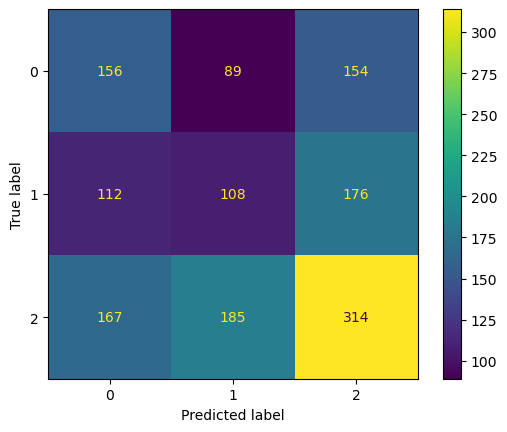

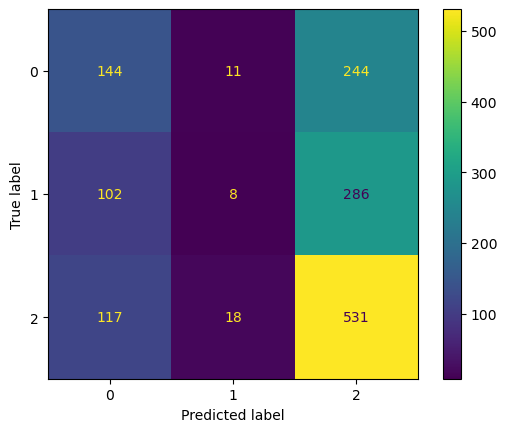

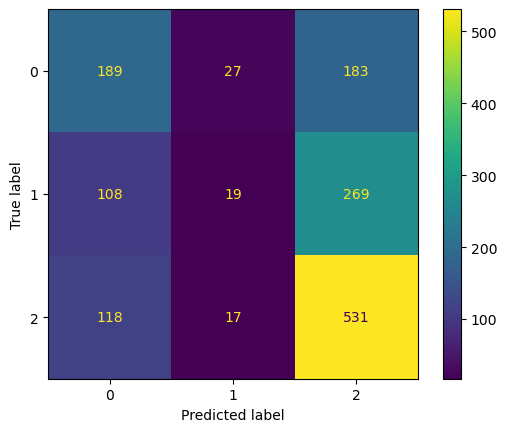

In [21]:
FTR_encoder = LabelEncoder()
y_test = FTR_encoder.fit_transform(y_test);
plot_confusion_matrix(DT_Model, X_test, y_test)
plot_confusion_matrix(KNN_Model, X_test, y_test)
plot_confusion_matrix(RF_Model, X_test, y_test)